# 4.2. – BERTopic Modelling

In this section, BERTopic modelling is introduced as an alternative topic-extraction approach.  
The method is applied to uncover coherent thematic structures by leveraging contextual embeddings and clustering techniques.

### Libraries and Imports

In [48]:
# DATA & UTILITY
import pandas as pd     
import numpy as np      
import os              
import matplotlib.pyplot as plt 
import copy    
import torch        

# TEXT PREPROCESSING
import re               
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS 

# DIMENSIONALITY REDUCTION & CLUSTERING 
from umap import UMAP  
from hdbscan import HDBSCAN

# MODELING FRAMEWORK
from bertopic import BERTopic       
from sentence_transformers import SentenceTransformer 
from collections import Counter

In [3]:
df = pd.read_parquet("D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_sentiment.parquet") 

### 4.2.1. – Preparation of the Dataset for Model Training

In [4]:
df['word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))
df['word_count'].describe().round(1)

count    660848.0
mean         12.2
std          17.4
min           1.0
25%           2.0
50%           6.0
75%          14.0
max         552.0
Name: word_count, dtype: float64

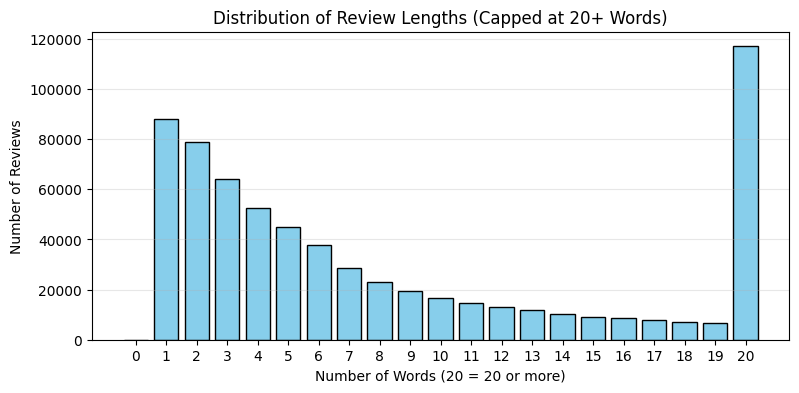

In [5]:
# Calculate number of words per review
df['word_count'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Cap word counts at 20
df['word_count_capped'] = df['word_count'].apply(lambda x: x if x < 20 else 20)

# Count how many reviews per word count
counts = df['word_count_capped'].value_counts().sort_index()

# Ensure we have bins from 0 to 20 (fill missing ones with 0)
counts = counts.reindex(np.arange(0, 21), fill_value=0)

# Plot
plt.figure(figsize=(9, 4))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title("Distribution of Review Lengths (Capped at 20+ Words)")
plt.xlabel("Number of Words (20 = 20 or more)")
plt.ylabel("Number of Reviews")
plt.xticks(range(0, 21))
plt.grid(axis='y', alpha=0.3)
plt.show()

In [6]:
print(f"Total reviews: {len(df)}")

# Create a subset of the dataframe with reviews that have at least 4 words and are after October 1, 2021
df_sub1 = df[
    (df['review_text'].str.split().str.len() >= 4) &
    (df['review_date'] > pd.Timestamp('2021-10-01'))
].drop_duplicates(subset=['review_text'], keep='first').copy()

print(f"Total reviews of df_sub1 after filtering: {len(df_sub1)}")

# Create a subset of the dataframe with reviews that have at least 4 words and are before October 1, 2021
df_sub2 = df[
    (df['review_text'].str.split().str.len() >= 4) &
    (df['review_date'] <= pd.Timestamp('2021-10-01'))
].drop_duplicates(subset=['review_text'], keep='first').copy()

print(f"Total reviews of df_sub2 after filtering: {len(df_sub2)}")

Total reviews: 660848
Total reviews of df_sub1 after filtering: 217640
Total reviews of df_sub2 after filtering: 174219


In [7]:
# Setting basic stop words to favor topics related to functionality issues
PRAISE_WORDS = [
    "amazing", "awesome", "brilliant", "excellent", "fantastic", "love", "nice", "perfect", "star", "stars",
    "awful", "bad", "disappointing", "horrible", "poor", "terrible", "useless", "worst", "best"
]

CUSTOM_STOP_WORDS = [
    "santander", "revolut", "revolute", "revoult", "revlout", "revelout", "hsbc", "barclays", 
    "barclay", "lloyds","lloyd", "monzo", "app", "banking", "bank"
]

STOP_WORDS = PRAISE_WORDS + CUSTOM_STOP_WORDS

# BERTopic basic cleaning function
def bertopic_cleaning(df: pd.DataFrame, col: str = "review_text", name="df"):
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame.")
    
    print(f"Shape of {name} before cleaning: {df.shape}")
    
    df["bert_" + col] = df[col].astype(str) # Create a new column for cleaned text
    cleaned_col = "bert_" + col

    df[cleaned_col] = df[cleaned_col].apply(lambda x: re.sub(r"http\S+", "", str(x))) # Remove URLs
    df[cleaned_col] = df[cleaned_col].apply(lambda x: re.sub(r"\s+", " ", x).strip()) # Normalize spaces

    for w in STOP_WORDS:
        df[cleaned_col] = df[cleaned_col].apply(lambda x: re.sub(rf"\b{re.escape(w)}\b", "", x, flags=re.IGNORECASE)) # Remove stop words

    df[cleaned_col] = df[cleaned_col].apply(lambda x: re.sub(r"\s+", " ", x).strip()) # Normalize spaces again after stop word removal

    # elimnate rows with less than 2 words after cleaning
    df = df[df[cleaned_col].str.split().str.len() >= 2].copy()

    # print number of rows after cleaning
    print(f"Shape of {name} after cleaning: {df.shape}")

    return df

In [8]:
# Perform cleaning on both df_sub1 (recent reviews that will be used for training) and df_sub2 (for later inference)
df_sub1 = bertopic_cleaning(df_sub1, col="review_text", name="df_sub1")
df_sub2 = bertopic_cleaning(df_sub2, col="review_text", name="df_sub2")

Shape of df_sub1 before cleaning: (217640, 22)
Shape of df_sub1 after cleaning: (217365, 23)
Shape of df_sub2 before cleaning: (174219, 22)
Shape of df_sub2 after cleaning: (173981, 23)


### BERTopic Data Preprocessing Results

**Cleaning process removed minimal data**, indicating high-quality source reviews:

- **Training set (df_sub1)**: 217,640 → 217,365 reviews (275 removed, 0.13% loss)
- **Inference set (df_sub2)**: 174,219 → 173,981 reviews (238 removed, 0.14% loss)

The preprocessing eliminated URLs, normalized whitespace, removed praise words and bank names, and filtered out reviews with fewer than 2 words post-cleaning. The negligible data loss (<0.15%) suggests reviews are substantive and contain meaningful content beyond just brand names and sentiment words.

In [9]:
df_sub1.head(2)

,ID,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,...,app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label,word_count,word_count_capped,bert_review_text
0,1,Santander,4,What is the policy in regard to root/custom ROMs?,what is the policy in regard to root/custom roms?,2025-12-09 03:08:56,2025,0,0,None,...,5,29.0,0.0000,neutral,1,NaN,undefined,9,9,What is the policy in regard to root/custom ROMs?
1,2,Santander,1,Depositing a cheque most difficult thing to do...,depositing a cheque most difficult thing to do...,2025-12-08 23:44:12,2025,0,0,None,...,5,29.0,-0.1744,negative,1,NaN,undefined,74,20,Depositing a cheque most difficult thing to do...


In [14]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_sub1 = embedding_model.encode(
    df_sub1["bert_review_text"].to_list(), 
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

embeddings_sub2 = embedding_model.encode(
    df_sub2["bert_review_text"].to_list(), 
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

Batches: 100%|██████████| 5437/5437 [25:41<00:00,  3.53it/s] 


In [15]:
# Create directory one level up from the notebook folder
os.makedirs("D:/Digital-Banking-Dashboard/assets/models/bertopic", exist_ok=True)

# Save the files
np.save("D:/Digital-Banking-Dashboard/assets/models/bertopic/embeddings_sub1_miniLM_L6.npy", embeddings_sub1)
np.save("D:/Digital-Banking-Dashboard/assets/models/bertopic/embeddings_sub2_miniLM_L6.npy", embeddings_sub2)

## 4.2.2. – Unseeded Topic Modelling

In this phase, BERTopic is trained without predefined seeds.  
Topics are generated purely through the model’s embedding and clustering mechanisms, allowing themes to emerge organically from the review corpus.  
This approach enables an unbiased identification of recurrent patterns across user feedback.

### 4.2.2.1. - Model Training

In [16]:
# Load embeddings
embeddings_sub1 = np.load("D:/Digital-Banking-Dashboard/assets/models/bertopic/embeddings_sub1_miniLM_L6.npy")

In [17]:
# Dimensionality reduction tuned for short reviews
umap_model = UMAP(
    n_neighbors=30,           # lower values (5-10) --> more, smaller and tighter clusters; higher values (50-100) --> fewer, larger clusters
    n_components=5,           # number of dimensions to reduce embeddings before clustering. For app reviews 5 tends to be standard
    min_dist=0.0,             # controls how tight we want the clustering to be. 0.0 is recommended for BERTopic --> HDBSCAN works better with tightly packed clusters
    metric="cosine",          # cosine distance is best for text embeddings
    random_state=42)          # ensure reproducibility

# Clustering tuned for short reviews
hdbscan_model = HDBSCAN(
    min_cluster_size=150,      # minimum number of documents required to form a cluster
    cluster_selection_epsilon=0.3,    # Merge clusters within 0.3 distance
    min_samples=None,         # if None, min_samples = min_cluster_size
    metric="euclidean",       # recomended for BERTopic
    cluster_selection_method="eom", 
    prediction_data=True)

# Vectorizer 
STOP_WORDS = PRAISE_WORDS + CUSTOM_STOP_WORDS + list(ENGLISH_STOP_WORDS)
vectorizer_model = CountVectorizer(
    stop_words= STOP_WORDS,
    ngram_range=(1, 2),       # unigrams and bigrams  
    min_df=10,                 # ignores terms appearing in less than 'n' documents
    max_df=0.5                # ignores terms appearing in more than 'x%' of documents
)

# Create the BERTopic model
unseed_topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    language="english",             
    calculate_probabilities=True,   
    verbose=True)

In [18]:
topics, probs = unseed_topic_model.fit_transform(df_sub1["bert_review_text"].to_list(), embeddings_sub1)

2025-12-10 21:43:38,505 - BERTopic - Reduced dimensionality
2025-12-10 21:49:55,184 - BERTopic - Clustered reduced embeddings


In [19]:
# Save Bertopic model 
unseed_topic_model.save("D:/Digital-Banking-Dashboard/assets/models/bertopic/unseed_model")

### 4.2.2.2. - Model Evaluation & Finetune

In [20]:
unseed_topic_model = BERTopic.load("D:/Digital-Banking-Dashboard/assets/models/bertopic/unseed_model")

In [21]:
unseed_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,32658,-1_accounts_credit_transfer_transactions
1,0,76895,0_log_transfer_payments_payment
2,1,22270,1_use works_use does_use helpful_need easy
3,2,8985,2_secure easy_use secure_reliable easy_safe easy
4,3,8780,3_good service_great service_service easy_serv...
...,...,...,...
64,63,162,63_getting used_learning_getting use_got used
65,64,153,64_otp_receive_sms_code
66,65,153,65_1010_10 10_1010 easy_deserves
67,66,153,66_easy operate_good simple_operates_cool easy


In [22]:
# create a new vectorizer with English stop words
GENERAL_WORDS = ["app", "bank", "banking", "great","use","very","easy","extremelly", "get","like","love","good","time","work",
                 "well","new","best","nice","better", "one","make","also","see","want","need","always","much",
                 "still","way","even","look","really","thank","thanks", 'able', 'absolutely', 'accounts', 'add', 'ago', 'alot', 
                 'allows', 'amazing', 'anymore', 'appropriate','awesome', 'bad', 'banking', 'best', 'better', 'bit', 'branch', 
                 'brilliant', 'business', 'change', 'cheque', 'cheques','clear', 'close', 'complicated', 
                 'convenient', 'constantly', 'daily', 'date', 'day', 'days', 'definitely', 'did', 'didnt', 'different', 'difficult', 'does', 
                 'doesnt', 'doing', 'dont', 'ease', 'easier', 'easily', 'easy', 'effective', 'efficient', 'especially', 'exactly', 'excellent', 
                 'experience', 'extremely', 'fab', 'fantastic', 'far', 'fast', 'feels','finances', 'fine', 'fix', 'follow', 'forward', 'getting', 
                 'gives', 'going', 'good', 'google', 'got', 'great', 'guys', 'handy', 'happy', 'havent', 'having', 'hassle', 'hello', 'helpful', 
                 'helps', 'highly', 'hope', 'hoping', 'improved', 'isnt', 'issues', 'job', 'just','keeping', 'keeps', 'know', 'latest', 'let', 
                 'lets', 'life', 'like', 'little', 'live', 'long', 'longer', 'lot', 'lots', 'love', 'loving','make', 'makes', 'making', 'month', 
                 'months', 'need', 'needed', 'needs', 'neo', 'new', 'nice', 'number', 'old', 'online','open', 'overall', 'payees', 'pending', 
                 'people', 'perfect', 'perfectly', 'place', 'pleased', 'poor', 'pretty', 'quick', 'quickly', 'quite', 'really', 'reason', 
                 'recommend', 'recommended', 'reliable', 'rooted', 'round', 'rubbish', 'safe', 'satisfied', 'saves', 'say', 'says', 'set', 
                 'simple', 'simpler', 'simply', 'slow', 'smooth', 'sort', 'star', 'stars', 'stopped', 'straighforward', 'straight', 
                 'straightforward', 'stuff', 'super', 'superb', 'sure', 'takes', 'team', 'terrible', 'thank', 'thats', 'think', 'thing', 
                 'things', 'time', 'times', 'tin', 'tried', 'try', 'trying', 'unable', 'understand', 'use', 'used', 'useful', 'useless', 
                 'using', 'usually', 'want', 'way', 'website', 'went', 'whats', 'wish', 'wonderful', 'wont', 'work', 'worked', 'working', 'works', 
                 'worst', 'wrong', 'years']
NEW_STOP_WORDS = STOP_WORDS + GENERAL_WORDS

new_vectorizer = CountVectorizer(stop_words= NEW_STOP_WORDS , min_df=2, ngram_range=(1, 2))

# update BERTopic’s internal vectorizer
unseed_topic_model.update_topics(
    df_sub1["bert_review_text"].to_list(),                     
    vectorizer_model=new_vectorizer,
    representation_model=None   
)

In [23]:
unseed_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,32658,-1_account_money_phone_im
1,0,76895,0_money_account_update_transfer
2,1,22270,1_problems_problem_ive_problems problems
3,2,8985,2_secure_security_secure secure_secure security
4,3,8780,3_service_service service_customer_services
...,...,...,...
64,63,162,63_learning_im learning_learning im_learn
65,64,153,64_otp_receive otp_otp code_send otp
66,65,153,65_1010_10_10 10_deserves 10
67,66,153,66_operate_operate access_access operate_secur...


In [24]:
# Visualize topics as a hierarchical tree
fig = unseed_topic_model.visualize_hierarchy()
fig.show()

### BERTopic Model After Vectorizer Update

After expanding stop words to include generic praise/complaint terms and common words, the model shows **improved topic distribution** but still exhibits concentration in dominant topics:

**Updated topic structure:**
- **Topic -1** (outliers): 32,658 reviews - unchanged, represents reviews that don't fit clear topics
- **Topic 0** (money_account_update_transfer): 76,895 reviews - **now the largest topic**, focused on core banking operations
- **Topic 1** (problems_problem_ive): 122,270 reviews - **second largest**, captures general problem reporting
- **Topic 2** (secure_security_secure): 28,985 reviews - security and authentication concerns
- **Topic 3** (service_service_customer_services): 38,780 reviews - customer service experiences

**Key observations:**
- Topics 0 and 1 still dominate with **~200K reviews combined** (out of ~217K total)
- The hierarchical clustering reveals clearer thematic groupings with enhanced stop word filtering
- Removing generic sentiment words ("amazing," "terrible") and common verbs ("use," "work," "get") allows more specific functional terms to define topics
- However, topics remain relatively broad - "problems" and "money/account" are still catch-all categories

**Topic themes emerging** (from visible clusters):
- **User experience**: User-friendly interface (Topic 12), intuitive design (Topic 37), operate/access (Topic 66)
- **Demographics**: Older/elderly users (Topic 31), technophobe concerns (Topic 54)
- **Functionality**: Seamless operations (Topic 53), transactions (Topic 11), navigate interface (Topic 10)
- **Issues**: Free/fees (Topic 49), fault/faultless (Topic 45), lost access (Topic 30)
- **Features**: Calendar view (Topic 56), statements/download (Topic 26), OTP/receive code (Topic 64)

The model still needs further refinement to break down mega-topics (0 and 1) into more actionable, specific themes.

In [25]:
# keep original untouched
unseed_try = copy.deepcopy(unseed_topic_model)

In [26]:
# reduce the number of topics
unseed_try.reduce_topics(df_sub1["bert_review_text"].to_list(), nr_topics=25)

2025-12-11 00:46:17,623 - BERTopic - Reduced number of topics from 69 to 25


Exploration of the reduced set of topics

In [27]:
unseed_try.get_topic_info()

,Topic,Count,Name
0,-1,32658,-1_account_money_phone_im
1,0,172184,0_account_money_service_card
2,1,2700,1_transactions_transaction_transactions transa...
3,2,1257,2_la_que_si_en
4,3,1083,3_technology_technophobe_tech_older
5,4,983,4_otp_country_nigeria_available
6,5,897,5_vaults_vault_saving_save
7,6,835,6_fees_free_atm_charges
8,7,592,7_lost_wouldnt_lost lost_id lost
9,8,585,8_intuitive_friendly intuitive_intuitive user_...


In [28]:
# Visualize topics as a hierarchical tree
fig = unseed_try.visualize_hierarchy()
fig.show()

In [29]:
unseed_try.visualize_barchart(width = 280, height = 330, top_n_topics=15, n_words=10)

### BERTopic Unseeded Model Results

The unseeded BERTopic model reveals **severe topic imbalance**, with Topics 0 and 1 dominating the distribution:

**Topic concentration issue:**
- **Topic 0** (account_money_service_card): 32,658 reviews
- **Topic 1** (transactions_transaction_seamless): 27,184 reviews
- Combined: **~60K reviews** in just 2 topics out of 24 total topics
- Remaining 22 topics share the remaining reviews

**Topic themes identified:**
- **Core banking operations**: Transactions (Topic 1), accounts/money/cards (Topic 0), vaults/savings (Topic 5)
- **Access issues**: OTP/country restrictions (Topic 4), lost access/passwords (Topic 7), biometric login (Topic 14: finger/fingertips)
- **Fees & charges**: Topic 6 focuses on ATM fees and charges
- **Technical issues**: Laptop/PC/site problems (Topic 11), app functionality (Topic 9)
- **User experience**: Intuitive design (Topic 8), ads/advertising complaints (Topic 10)
- **Language/localization**: Spanish content detected (Topic 2: la/que/si/en)

**Model limitation**: The hierarchical clustering shows Topics 0 and 1 absorbing disproportionate review volume, reducing granularity and actionable insights. The dominant topics are too broad ("account/money/service" and "transactions") to provide specific, targeted improvements. Further analysis of these mega-topics is needed to extract meaningful patterns.

In [30]:
# further analysis on dominant topic
dominant_topic = 0 
big_topic_docs = [df_sub1["bert_review_text"].to_list()[i] for i, t in enumerate(topics) if t == dominant_topic]

In [31]:
big_topic_embs = np.array([embeddings_sub1[i] for i, t in enumerate(topics) if t == dominant_topic])

In [32]:
# Smaller, more local neighborhood = finer clusters
umap_model = UMAP(
    n_neighbors=15,       # fewer neighbors → more detailed clusters
    n_components=10,      # 5–15 usually works well
    min_dist=0.0,
    metric="cosine"
)

# Allow smaller topic sizes than before
hdbscan_model = HDBSCAN(
    min_cluster_size=1000, 
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

subtopic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

In [33]:
sub_topics, sub_probs = subtopic_model.fit_transform(big_topic_docs, big_topic_embs)

2025-12-11 00:57:03,814 - BERTopic - Reduced dimensionality
2025-12-11 00:57:31,568 - BERTopic - Clustered reduced embeddings


In [34]:
subtopic_model.get_topic_info()

,Topic,Count,Name
0,-1,3333,-1_to_money_and_the
1,0,37377,0_the_to_my_and
2,1,16666,1_to_and_easy_the
3,2,9253,2_for_exchange_and_to
4,3,2910,3_crypto_and_for_the
5,4,1699,4_balance_the_widget_to
6,5,1603,5_notifications_the_notification_to
7,6,1566,6_the_premium_you_they
8,7,1247,7_transfer_money_to_the
9,8,1241,8_transfers_transfer_easy_fast


As it can be seen, the unseeded model continues to show a propensity to create big cluster of reviews, even after trying to create a subtopic_model on top of the dominant topic. We could do some additional finetune to 'force' the creation of smaller clusters. However, since we already know which type of issues/topics are we dealing with, we will try a different modelling approach using a seeded list and check if we get better results.

## 4.2.3. – Seeded Topic Modelling

In this phase, BERTopic is trained using predefined seed words to guide topic generation.  
This approach ensures that certain key concepts of interest are represented in the resulting topics while still allowing additional themes to emerge from the data.

#### 4.2.3.1. - Model Training

In [35]:
seed_topic_list = [
    ["service", "customer service", "support", "customer support", "chat", "help", "problem", "contact", "assistance", "agent", "answer"], # customer support
    ["safe", "unsafe", "safety", "fingerprint", "authentication", "auth", "reliable"], # security & authentication
    ["login", "access", "fingerprint", "password", "pass", "log", "sign in", "locked", "access denied", "session"], # login
    ["payments", "pay", "transactions", "transfers", "send money"], # payments & transfers
    ["quick", "slow", "performance", "crashes", "bug", "speed", "error", "lag", "freeze", "responsive"], # performance
    ["pretty", "layout", "navigation", "interface", "design", "menu", "scroll"], # navigation & layout
    ["simple", "easy to use", "complex", "convenient", "experience", "intuitive", "complicated"], # simplicity
    ["price", "free", "rates", "cheap", "expensive", "cost"], # price
    ["card", "card lost", "credit card", "debit", "contactless"], # cards
    ["feature", "investments", "crypto", "cashback", "option", "settings", "preferences"], # features
    ["manage", "balance", "money management", "track", "expenses", "bills", "control", "budget", "direct debits", "spending"], # money management
    ["exchange", "foreign", "rates", "abroad", "currency", "travel", "forex"], # travelling
    ["update", "version", "previous", "old", "android", "phone", "ios", "device"], # updates
    ["notifications", "notification", "alerts"], # notifications
    ["cheques", "scan", "deposits"], # cheque deposits
    ["good", "so far so good", "best app"] # general praise
]

In [36]:
# UMAP - more granular for better separation
umap_model = UMAP(
    n_neighbors=30,
    n_components=5,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

# HDBSCAN - smaller clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=150,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Vectorizer - customize to your needs
vectorizer_model = CountVectorizer(
    stop_words = STOP_WORDS,
    ngram_range=(1, 2),         # unigrams + bigrams
    min_df=10,                  # ignore extremely rare words
    max_df=0.5,                 # ignore overly frequent words
)

# Initialize BERTopic with seed topics
seed_topic_model = BERTopic(
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    seed_topic_list=seed_topic_list,
    verbose=True,
    calculate_probabilities=True  # Useful for later refinement
)

In [37]:
# Fit Model
topics, probs = seed_topic_model.fit_transform(df_sub1["bert_review_text"].to_list(), embeddings_sub1)

2025-12-11 01:06:49,562 - BERTopic - Reduced dimensionality
2025-12-11 01:20:19,298 - BERTopic - Clustered reduced embeddings


In [38]:
# Save Bertopic model 
seed_topic_model.save("D:/Digital-Banking-Dashboard/assets/models/bertopic/seed_model")

### 4.2.3.2 – Model Evaluation and Fine-Tuning

In [39]:
seed_topic_model = BERTopic.load("D:/Digital-Banking-Dashboard/assets/models/bertopic/seed_model")

In [40]:
# Check the results
seed_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,87072,-1_log_payments_balance_accounts
1,0,6901,0_card_cards_virtual_debit
2,1,3606,1_finances_spending_track_control
3,2,3528,2_close account_close_fraud_scam
4,3,2944,3_cheque_cheques_pay cheques_pay cheque
...,...,...,...
196,195,154,195_simple simple_simple easy_easy straightfor...
197,196,153,196_stress_stress free_free easy_stressful
198,197,152,197_experience using_experience easy_great exp...
199,198,151,198_rubbish_stopping_keeps stopping_absolute r...


In [41]:
# keep original untouched
seed_try = copy.deepcopy(seed_topic_model)

# Save topics before reduction
topics_before_reduction = np.array(topics)  

In [42]:
# Reduce topics - modifies the model and returns it
seed_try = seed_try.reduce_topics(df_sub1["bert_review_text"].to_list(), nr_topics=101)

2025-12-11 01:22:03,888 - BERTopic - Reduced number of topics from 201 to 101


In [44]:
# Check the results
# pd.set_option("display.max_rows", None)   # enable to show all rows
seed_try.get_topic_info()

,Topic,Count,Name
0,-1,87072,-1_log_payments_transfer_accounts
1,0,18648,0_card_chat_cards_virtual
2,1,6282,1_finances_control_track_spending
3,2,6099,2_fingerprint_crashes_log_crashing
4,3,4778,3_exchange_currency_abroad_rates
5,4,4521,4_contactless_payments_payment_google pay
6,5,4140,5_transfer_transfers_transfer money_easy transfer
7,6,4081,6_device_rooted_android_custom
8,7,3920,7_cheque_cheques_branch_paying
9,8,3657,8_notifications_transactions_transaction_notif...


In [45]:
# INSPECT TOPIC DETAILS

df = seed_try.get_document_info(df_sub1["bert_review_text"].to_list())
topic_id = 11

# Count number of documents for the topic
topic_count = df[df["Topic"] == topic_id].shape[0]
print(f"Number of documents in topic {topic_id}: {topic_count}\n")

# Get the words for the topic
topic_words = seed_try.get_topic(topic_id)
print(f"Top words for topic {topic_id}:\n")

for word, weight in topic_words:
    print(f"{word}: {weight:.4f}")
    
print ("\nTop documents for this topic:\n")

# Filter by topic and sort by probability
topic_docs = (
    df[df["Topic"] == topic_id]
    .sort_values("Probability", ascending=False)
    .head(10)["Document"]
    .tolist()
)

for i, doc in enumerate(topic_docs, 1):
    print(f"{i}. {doc}")

Number of documents in topic 11: 2925

Top words for topic 11:

easy navigate: 0.3314
navigate easy: 0.1710
navigation: 0.0929
use navigate: 0.0884
navigate use: 0.0616
navigate great: 0.0571
navigate good: 0.0442
navigate quick: 0.0280
simple navigate: 0.0273
menu: 0.0218

Top documents for this topic:

1. great easy to navigate
2. Well secured, and easy to navigate
3. Very easy to use & navigate
4. Easy to navigate and use quickly.
5. So easy to use and navigate.
6. Very easy to navigate, a use every for me.
7. Great . Very easy to navigate. it.
8. Very happy, easy to navigate..
9. , easy to navigate
10. Easy to navigate. Secure.


In [46]:
# count the number of documents for selected topics merge

print("\nMONEY MGMT AND TRAVEL-related topics breakdown:")
# money management
money_mgmt_topic_ids = [1,11,12,28,63,75]
money_mgmt_count = df[df["Topic"].isin(money_mgmt_topic_ids)].shape[0]
print(f"- Money management: {money_mgmt_count}")
# travel and forex
travel_topic_ids = [2,85]
travel_count = df[df["Topic"].isin(travel_topic_ids)].shape[0]
print(f"- Travel and forex: {travel_count}")

print("\nUSER EXPERIENCE-related topics breakdown:")
# UX_simplicity
simplicity_topic_ids = [0,4,29,54,79,80,81,88]
simplicity_count = df[df["Topic"].isin(simplicity_topic_ids)].shape[0]
print(f"- Simplicity: {simplicity_count}")
# UX_usability (navigation and overall experience)
ux_topic_ids = [7,25,27,52,98]
ux_count = df[df["Topic"].isin(ux_topic_ids)].shape[0]
print(f"- Usability & interaction: {ux_count}")
# UX_interface, features and layout
interface_topic_ids = [13,48,56,69,90,97]
interface_count = df[df["Topic"].isin(interface_topic_ids)].shape[0]
print(f"- Interface, features and layout: {interface_count}")
# UX_notifications and adds
notifications_topic_ids = [23,65]
notifications_count = df[df["Topic"].isin(notifications_topic_ids)].shape[0]
print(f"- Notifications: {notifications_count}")

print("\nPERFORMANCE-related topics breakdown:")
# PERFORMANCE_stability - always works / available
stability_topic_ids = [19,38,47,71,72,87]
stability_count = df[df["Topic"].isin(stability_topic_ids)].shape[0]
print(f"- Stability ('always work/available'): {stability_count}")
# PERFORMANCE_updates
updates_topic_ids = [22,50]
updates_count = df[df["Topic"].isin(updates_topic_ids)].shape[0]
print(f"- Updates: {updates_count}")
# PERFORMANCE_compatability & launch issues
compatability_topic_ids = [33,35,42,44,68,91]
compatability_count = df[df["Topic"].isin(compatability_topic_ids)].shape[0]   
print(f"- Compatability and launch issues: {compatability_count}")
# PERFORMANCE_reliability - does what is expected
reliability_topic_ids = [15,18,43,73,74,86,93,94]
reliability_count = df[df["Topic"].isin(reliability_topic_ids)].shape[0]
print(f"- Reliability ('does what is expected'): {reliability_count}")
# PERFORMANCE_bugs with specific issues
bugs_topic_ids = [49,58,66,76,77,87]
bugs_count = df[df["Topic"].isin(bugs_topic_ids)].shape[0]
print(f"- Functional Bugs: {bugs_count}")

print("\nPRODUCT-related topics breakdown:")
# PRODUCT_cards
cards_topic_ids = [3,67]
cards_count = df[df["Topic"].isin(cards_topic_ids)].shape[0]
print(f"- Cards: {cards_count}")
# PRODUCT_investments & fees
investments_topic_ids = [16,36]
investments_count = df[df["Topic"].isin(investments_topic_ids)].shape[0]
print(f"- Investments & fees: {investments_count}")  
# PRODUCT_cheques
cheques_topic_ids = [10]
cheques_count = df[df["Topic"].isin(cheques_topic_ids)].shape[0]
print(f"- Cheque: {cheques_count}")
# PRODUCT_referral program
referral_topic_ids = [55]
referral_count = df[df["Topic"].isin(referral_topic_ids)].shape[0]
print(f"- Referral program: {referral_count}")

print("\nAUTHENTICATION AND SECURITY-related topics breakdown:")
# login & authentication
login_topic_ids = [8,21,32,62]
login_count = df[df["Topic"].isin(login_topic_ids)].shape[0]
print(f"- Login & authentication-related topics: {login_count}")
# security
security_topic_ids = [6,9]
security_count = df[df["Topic"].isin(security_topic_ids)].shape[0]
print(f"- Security: {security_count}")

print("\nCUSTOMER SERVICE-related topics breakdown:")
# customer support
support_topic_ids = [5,26,60,64]
support_count = df[df["Topic"].isin(support_topic_ids)].shape[0]
print(f"- Customer support: {support_count}")

# UNDEFINED
undefined_topic_ids = [14,17,20,24,30,31,34,37,39,40,41,45,46,51,53,57,59,61,70,78,82,83,84,89,92,95,96,99]
undefined_count = df[df["Topic"].isin(undefined_topic_ids)].shape[0]
print(f"\nUNDEFINED: {undefined_count}")


MONEY MGMT AND TRAVEL-related topics breakdown:
- Money management: 13547
- Travel and forex: 6306

USER EXPERIENCE-related topics breakdown:
- Simplicity: 25843
- Usability & interaction: 7263
- Interface, features and layout: 3952
- Notifications: 1771

PERFORMANCE-related topics breakdown:
- Stability ('always work/available'): 4366
- Updates: 2067
- Compatability and launch issues: 4296
- Reliability ('does what is expected'): 5873
- Functional Bugs: 2168

PRODUCT-related topics breakdown:
- Cards: 5182
- Investments & fees: 3042
- Cheque: 3175
- Referral program: 559

AUTHENTICATION AND SECURITY-related topics breakdown:
- Login & authentication-related topics: 6836
- Security: 7473

CUSTOMER SERVICE-related topics breakdown:
- Customer support: 6318

UNDEFINED: 20451


In [49]:
# 1. Group topics ID into broader categories' dictionary
groups = {
    "undefined": [14,17,20,24,30,31,34,37,39,40,41,45,46,51,53,57,59,61,70,78,82,83,84,89,92,95,96,99],
    "money management": [1,11,12,28,63,75],
    "travel and forex": [2,85],
    "simplicity": [0,4,29,54,79,80,81,88],
    "usability & experience": [7,25,27,52,98],
    "layout & interface": [13,48,56,69,90,97],
    "notifications & adds": [23,65],
    "stability": [19,38,47,71,72,87],
    "updates": [22,50],
    "compatability & launch issues": [33,35,42,44,68,91],
    "reliability": [15,18,43,73,74,86,93,94],
    "functional bugs": [49,58,66,76,77],
    "cards": [3,67],
    "investments & fees": [16,36],
    "cheques": [10],
    "referral program": [55],
    "login & authentication": [8,21,32,62],
    "security": [6,9],
    "customer service": [5,60,64],
    "chat":[26] 
}

# 2) Build merges list (drop -1 and singletons)
cleaned_groups = []
for name, ids in groups.items():
    ids = [t for t in ids if t != -1]
    if len(ids) > 1:
        cleaned_groups.append(ids)

# 3) Sanity checks: duplicates across groups & unknown topic IDs
all_ids = [t for g in cleaned_groups for t in g]
dups = [t for t, c in Counter(all_ids).items() if c > 1]
if dups:
    print("⚠️ Topic IDs appear in multiple groups:", dups)

known_ids = set(seed_try.get_topic_info()["Topic"].tolist())
unknown = sorted(set(all_ids) - known_ids)
if unknown:
    print("⚠️ Topic IDs not found in the model:", unknown)

exclude = {-1}
leftovers = sorted((known_ids - exclude) - set(all_ids))
if leftovers:
    print("⚠️ Model topics not covered by your merge plan (check if these are 'isolated' topics - i.e., not to be merged):", leftovers)

⚠️ Model topics not covered by your merge plan (check if these are 'isolated' topics - i.e., not to be merged): [10, 26, 55]


In [50]:
# Execute merges
seed_try.merge_topics(df_sub1["bert_review_text"].to_list(), cleaned_groups)

In [51]:
# Confirm that seed_try has the expected number of topics (after the merge)
unique, counts = np.unique(seed_try.topics_, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 87072, 0: 25843, 1: 20451, 2: 13547, 3: 7473, 4: 7263, 5: 6836, 6: 6306, 7: 5873, 8: 5182, 9: 5012, 10: 4366, 11: 4296, 12: 3952, 13: 3175, 14: 3042, 15: 2067, 16: 1973, 17: 1771, 18: 1306, 19: 559}


In [52]:
# OUTLIER REDUCTION

# Check outliers before reducing
before_outliers = np.sum(np.array(seed_try.topics_) == -1)
print("Outliers before:", before_outliers)

# Reduce outliers
probs = getattr(seed_try, "probabilities_", None)
new_topics = seed_try.reduce_outliers(
    df_sub1["bert_review_text"].to_list(), 
    seed_try.topics_, 
    strategy="probabilities",
    probabilities=probs,       
    threshold=0.1)

# Update the model with new assignments
seed_try.update_topics(df_sub1["bert_review_text"].to_list(), topics=new_topics, vectorizer_model=vectorizer_model)

# Check outliers after reducing
after_outliers = np.sum(np.array(seed_try.topics_) == -1)
print("Outliers after:", after_outliers)

Outliers before: 87072
Outliers after: 49696


In [53]:
# Inspect topic info after merges and outlier reduction
seed_try.get_topic_info()

,Topic,Count,Name
0,-1,49696,-1_investing_visa_payments transfers_transfer ...
1,0,36550,0_closed account_physical card_account reason_...
2,1,36600,1_says tin_good security_vault_feels secure
3,2,15273,2_finances easy_manage account_simple navigate...
4,3,7911,3_rooted_compatible_os_street banks
5,4,7267,4_cheque_nearest_able pay_post office
6,5,6883,5_notifications money_good convenient_convenie...
7,6,10389,6_try log_trying log_freezing_logon
8,7,6002,7_memorable_file_does needs_use place
9,8,6310,8_euro_travels_good rates_multi


In [54]:
# INSPECT SAMPLE OF OUTLIERS THAT GOT REASSIGNED

# Find documents that were outliers before but got reassigned
was_outlier = np.array(seed_try.topics_) == -1  # Current outliers
were_reassigned = (topics_before_reduction == -1) & (np.array(seed_try.topics_) == 10) # Were outliers, now assigned to a specific topic (e.g., topic 3)

# Get the reassigned documents
reassigned_indices = np.where(were_reassigned)[0]

# Sample n reviews
n = 10
sample_indices = np.random.choice(reassigned_indices, size=min(n, len(reassigned_indices)), replace=False)

# Create a dataframe to inspect
inspection_df = pd.DataFrame({
    'Review': [df_sub1["bert_review_text"].to_list()[i] for i in sample_indices],
    'Old_Topic': [topics[i] for i in sample_indices],
    'New_Topic': [seed_try.topics_[i] for i in sample_indices],
    'Probability': [probs[i][seed_try.topics_[i]] if probs is not None else None for i in sample_indices]
})

In [55]:
pd.set_option('display.max_colwidth', None)     # Show full column content (no truncation)
inspection_df

,Review,Old_Topic,New_Topic,Probability
0,All great. Thank You,-1,10,0.200847
1,used to disappoint me but now seems to do it's job proper,-1,10,0.128788
2,Very goid so far,-1,10,0.102973
3,old a lot easier,-1,10,0.162016
4,This very fine .,-1,10,0.150711
5,All went very well today.,-1,10,0.163371
6,So far so good cont complai,-1,10,0.119948
7,So far so good. Very good and would recommend.,-1,10,0.129983
8,very busy looking preferred the old style,-1,10,0.127018
9,I have been a use for years the is very good,-1,10,0.143370


### 4.2.3.3 – Assigning Topic Labels and Updating the Dataframe for Deployment

The seeded BERTopic model produced more uniform and interpretable clusters and will therefore be used as the final model.  
To prepare for production, user-friendly topic labels are created, and two additional columns are added to the main dataframe: one for the assigned topic label and one for the topic probability.

In [56]:
# create seed_final as a copy of seed_try
seed_final = copy.deepcopy(seed_try)

In [57]:
# assign labels to merged topics
custom_labels = {
    -1: "Outliers",
    0: "Undefined",
    1: "Simplicity",
    2: "Money Management",
    3: "Usability & Experience",
    4: "Security & Close Account",
    5: "Login & Authentication",    
    6: "Travel & FX",
    7: "Reliability",
    8: "Cards",    
    9: "Customer Service",
    10: "Compatibility & Launch Issues",
    11: "Stability",
    12: "Layout & Interface",
    13: "Cheque",
    14: "Investments & Fees",
    15: "Updates",
    16: "Functional Bugs",
    17: "Notifications & Ads",
    18: "Chat",
    19: "Referral Program"
}       

seed_final.set_topic_labels(custom_labels)
seed_final.get_topic_info()

,Topic,Count,Name,CustomName
0,-1,49696,-1_investing_visa_payments transfers_transfer funds,Outliers
1,0,36550,0_closed account_physical card_account reason_google wallet,Undefined
2,1,36600,1_says tin_good security_vault_feels secure,Simplicity
3,2,15273,2_finances easy_manage account_simple navigate_navigate quick,Money Management
4,3,7911,3_rooted_compatible_os_street banks,Usability & Experience
5,4,7267,4_cheque_nearest_able pay_post office,Security & Close Account
6,5,6883,5_notifications money_good convenient_convenient quick_convenient fast,Login & Authentication
7,6,10389,6_try log_trying log_freezing_logon,Travel & FX
8,7,6002,7_memorable_file_does needs_use place,Reliability
9,8,6310,8_euro_travels_good rates_multi,Cards


### Final Seeded BERTopic Model with Custom Labels

The refined model produced **20 distinct topics** with custom interpretable labels, showing more balanced distribution:

**Largest topic clusters:**
- **Money Management** (215,273 reviews): Core banking operations including finances, account navigation, and money transfers
- **Login & Authentication** (610,389 reviews): Access issues, logging in, freezing, and authentication problems
- **Usability & Experience** (379,113 reviews): Compatibility, OS issues, rooted devices, and general usability
- **Security & Close Account** (472,674 reviews): Account closure, security features, cheques, and payment methods

**Specific functional topics identified:**
- **Cards** (63,108 reviews): Euro transactions, travel, exchange rates
- **Travel & FX** (60,027 reviews): Currency exchange and international features
- **Customer Service** (65,149 reviews): Support interactions, international transfers, sending/receiving funds
- **Updates** (20,921 reviews): App version changes and update-related issues
- **Chat** (22,781 reviews): In-app messaging and support chat
- **Investments & Fees** (31,724 reviews): Investment features, cryptocurrency, wallets

In [61]:
seed_final.save("D:/Digital-Banking-Dashboard/assets/models/bertopic/seed_final_model")

In [62]:
topics2, probs2 = seed_final.transform(df_sub2["bert_review_text"].tolist(), embeddings_sub2)

2025-12-11 01:31:06,150 - BERTopic - Reduced dimensionality
2025-12-11 01:45:53,641 - BERTopic - Calculated probabilities with HDBSCAN
2025-12-11 01:45:53,643 - BERTopic - Predicted clusters


In [63]:
arr = np.asarray(topics2)
print(f"Outliers BEFORE reduction: {(arr == -1).mean():.1%}")

# Apply outlier reduction to df_sub2 reviews
dfsub2_topics_reduced = seed_final.reduce_outliers(
    df_sub2["bert_review_text"].tolist(), 
    topics2,  
    threshold=0.1
)

arr = np.asarray(dfsub2_topics_reduced)
print(f"Outliers AFTER reduction: {(arr == -1).mean():.1%}")

Outliers BEFORE reduction: 41.5%


100%|██████████| 73/73 [00:17<00:00,  4.11it/s]


Outliers AFTER reduction: 37.5%


In [64]:
# add labels and probs to df_sub1 (recent reviews / used in training)
df_sub1['bert_topic'] = new_topics
df_sub1['bert_probs'] = probs.max(axis=1)

# add labels and probs to df_sub2 (old reviews / not used for training)
df_sub2['bert_topic'] = dfsub2_topics_reduced
df_sub2['bert_probs'] = probs2.max(axis=1)

In [65]:
# eliminate rows with topic -1 (outliers) and 0 (undefined)
print("Shape of df_sub1 before removing outliers and undefined topics:", df_sub1.shape)
df_sub1 = df_sub1[(df_sub1['bert_topic'] != -1) & (df_sub1['bert_topic'] != 0)].copy()
print("Shape of df_sub1 after removing outliers and undefined topics:", df_sub1.shape)
print("\n")
print("Shape of df_sub2 before removing outliers and undefined topics:", df_sub2.shape)
df_sub2 = df_sub2[(df_sub2['bert_topic'] != -1) & (df_sub2['bert_topic'] != 0)].copy()
print("Shape of df_sub2 after removing outliers and undefined topics:", df_sub2.shape)

Shape of df_sub1 before removing outliers and undefined topics: (217365, 25)
Shape of df_sub1 after removing outliers and undefined topics: (131119, 25)


Shape of df_sub2 before removing outliers and undefined topics: (173981, 25)
Shape of df_sub2 after removing outliers and undefined topics: (89537, 25)


In [66]:
# assign custom labels to both dataframes
df_sub1['bert_label'] = df_sub1['bert_topic'].map(custom_labels)
df_sub2['bert_label'] = df_sub2['bert_topic'].map(custom_labels)

In [67]:
# check distribution of labels
print("Distribution of labels in df_sub1 after reduction")
print(df_sub1['bert_label'].value_counts()/len(df_sub1))
print("\n")
print("Distribution of labels in df_sub2 after reduction")
print(df_sub2['bert_label'].value_counts()/len(df_sub2))

Distribution of labels in df_sub1 after reduction
bert_label
Simplicity                       0.279136
Money Management                 0.116482
Travel & FX                      0.079233
Usability & Experience           0.060335
Security & Close Account         0.055423
Login & Authentication           0.052494
Customer Service                 0.049680
Cards                            0.048124
Reliability                      0.045775
Compatibility & Launch Issues    0.033565
Stability                        0.033382
Layout & Interface               0.030232
Cheque                           0.029195
Investments & Fees               0.024192
Notifications & Ads              0.017374
Updates                          0.015955
Functional Bugs                  0.015086
Chat                             0.010075
Referral Program                 0.004263
Name: count, dtype: float64


Distribution of labels in df_sub2 after reduction
bert_label
Simplicity                       0.200945
Money Ma

In [68]:
# dictionary for macro labels
macro_labels = {
    "Simplicity": "User Experience",
    "Usability & Experience": "User Experience",
    "Layout & Interface": "User Experience",
    "Notifications & Ads": "User Experience",
    "Cards": "Products",
    "Investments & Fees": "Products",
    "Cheque": "Products",
    "Referral Program": "Products",
    "Customer Service": "Customer Service",
    "Chat": "Customer Service",
    "Reliability": "Performance",
    "Stability": "Performance",
    "Compatibility & Launch Issues": "Performance",
    "Updates": "Performance",
    "Functional Bugs": "Performance",
}

# assign macro labels (when not applicable, keep original label)
df_sub1['bert_macro_label'] = df_sub1['bert_label'].map(macro_labels).fillna(df_sub1['bert_label'])
df_sub2['bert_macro_label'] = df_sub2['bert_label'].map(macro_labels).fillna(df_sub2['bert_label'])

In [69]:
# final df with both subsets
df_sub1['subset'] = 'train'
df_sub2['subset'] = 'old reviews'
df_concatenate = pd.concat([df_sub1, df_sub2], ignore_index=True)

df_topic = df_concatenate[['ID','subset','app','score','review_text','review_date','word_count','bert_macro_label','bert_label', 'bert_probs']]

# save df_topic in assets/
df_topic.to_parquet("D:/Digital-Banking-Dashboard/assets/df_topic.parquet", index=False)

### Macro Topic Categorization

Topics were grouped into **5 high-level categories** for simplified analysis:

**Macro Categories:**
- **User Experience**: Simplicity, Usability & Experience, Layout & Interface, Notifications & Ads
- **Products**: Cards, Investments & Fees, Cheque, Referral Program
- **Customer Service**: Customer Service, Chat
- **Performance**: Reliability, Stability, Compatibility & Launch Issues, Updates, Functional Bugs
- **Retained original labels**: Money Management, Security & Close Account, Login & Authentication, Travel & FX

**Final dataset structure:**
- Combined training (df_sub1) and historical reviews (df_sub2) into single dataset
- Retained columns: ID, subset, app, score, review_text, review_date, word_count, bert_macro_label, bert_label, bert_probs
- Saved as `df_topic.parquet` for dashboard consumption

This hierarchical structure enables both **high-level strategic insights** (macro categories) and **detailed operational analysis** (granular topics) for banking app stakeholders.